In [17]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os

In [18]:
import importlib 
import src.var_net as var_net
import src.linear_var_hypernet as linear_var_hypernet
import src.base_net  as base_net
import src.utils as utils
importlib.reload(var_net)
importlib.reload(linear_var_hypernet)
importlib.reload(base_net)
importlib.reload(utils)
import json


In [19]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [20]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 25 #количество эпох
hidden_num = 100 # количество нейронов на скрытом слое
lamb = [0.01, 0.1, 1,  10, 100]
start_num = 5

lambda_encode = t.log
lambda_sample_num = 5
path_to_save = 'saved_mnist_lr'

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

In [21]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)

def test_acc(net): # точность классификации
    acc = []    
    correct = 0
    net.eval()
    for x,y in test_loader: 
        x = x.to(device)
        y = y.to(device)  
        out = net(x)    
        correct += out.argmax(1).eq(y).sum().cpu().numpy()
    acc = (correct / len(test_data))

    return acc




In [22]:
def train_batches(net, loss_fn, optimizer, lam, label, rep = False):
    tq = tqdm.tqdm(train_loader)
    losses = []
    for x,y in tq:            
        x = x.to(device)
        y = y.to(device)          
        optimizer.zero_grad()  
        loss = 0
        if lam is None:
            for _ in range(lambda_sample_num):  
                p = t.rand(1).to(device)*4 -2
                lam_param = 10**p[0]                
                #t.rand(1).to(device)[0]*100.0                  
                out = net(x, lambda_encode(lam_param))
                loss = loss + loss_fn(out, y)/lambda_sample_num
                if rep:
                    loss += net.KLD(lambda_encode(lam_param), rep)/len(train_data)/lambda_sample_num
                else:
                    loss += net.KLD(lambda_encode(lam_param))*lam_param/len(train_data)/lambda_sample_num
                losses+=[loss.cpu().detach().numpy()]
            # правдоподобие должно суммироваться по всей обучающей выборке
            # в случае батчей - она приводится к тому же порядку 
        else:
            out = net(x)
            loss = loss + loss_fn(out, y)
            loss += net.KLD(lam)/len(train_data)
            losses+=[loss.cpu().detach().numpy()]
        tq.set_description(label+str(np.mean(losses)))
        loss.backward()       
        clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
        optimizer.step()

In [7]:
t.manual_seed(0)
for lam in lamb:
    for start in range(start_num):                    
            net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                          act=lambda x:x))
            
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                train_batches(net, loss_fn, optim, lam, label)
            t.save(net.state_dict(), os.path.join(path_to_save, 'var_net_lam_{}_start_{}.cpk'.format(lam, start)))

/mnt/Memory/iad/VarHyperNet/code/src/var_net.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
lambda 100, epoch 21: 2.9716227: 100%|██████████| 235/235 [00:10<00:00, 21.89it/s]


lambda 100, epoch 24: 2.9532855: 100%|██████████| 235/235 [00:12<00:00, 18.66it/s]


In [ ]:
t.manual_seed(0)
for lam in lamb:
    for start in range(start_num):                    
            net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                          act=lambda x:x))
            
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                train_batches(net, loss_fn, optim, lam, label, rep = True)
            t.save(net.state_dict(), os.path.join(path_to_save, 'rep_net_lam_{}_start_{}.cpk'.format(lam, start)))

In [8]:
t.manual_seed(0)
for lam in lamb:
    for start in range(start_num):                    
            net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device), 
                     base_net.BaseLayer(hidden_num, 10, device,
                              act=lambda x:x))
            
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                train_batches(net, loss_fn, optim, lam, label)
            t.save(net.state_dict(), os.path.join(path_to_save, 'base_net_lam_{}_start_{}.cpk'.format(lam, start)))

/mnt/Memory/iad/VarHyperNet/code/src/base_net.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)
lambda 0.1, epoch 14: 0.09028379: 100%|██████████| 235/235 [00:14<00:00, 16.28it/s] 


lambda 10, epoch 11: 0.104439676: 100%|██████████| 235/235 [00:14<00:00, 16.27it/s]


lambda 100, epoch 6: 0.16186842: 100%|██████████| 235/235 [00:14<00:00, 16.37it/s]


lambda 100, epoch 24: 0.056997545: 100%|██████████| 235/235 [00:14<00:00, 16.38it/s]


In [8]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                          act=lambda x:x)).to(device)

lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join(path_to_save, 'var_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(utils.delete_10(net, device, lambda:test_acc(net), layer_num=2))
import json
with open(os.path.join(path_to_save, 'results_var.json'),'w') as out:
    out.write(json.dumps(lam_results))        

100 0
100 1
100 2
100 3
100 4


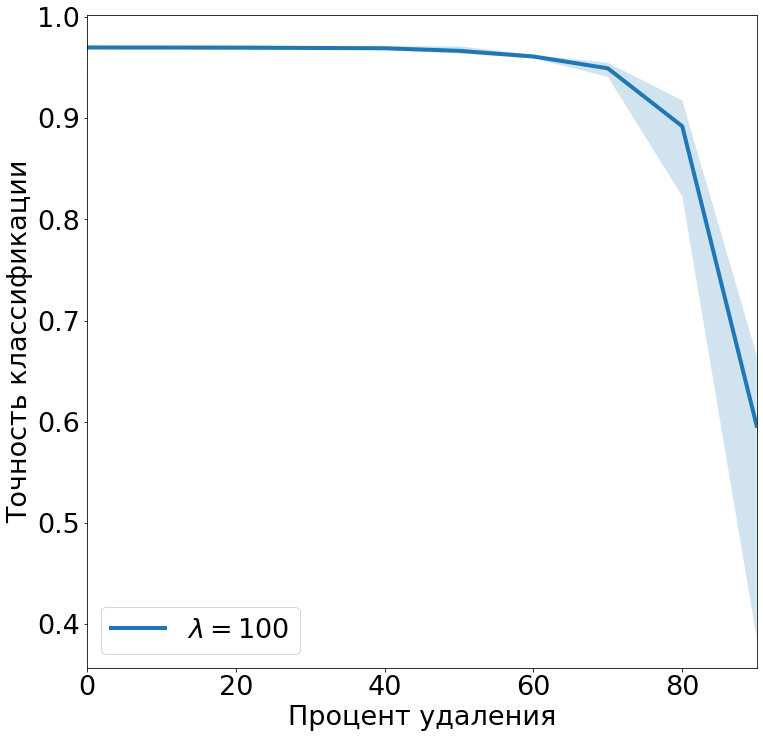

In [9]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('VarNer.png')
plt.show()


In [11]:
net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device), 
                     base_net.BaseLayer(hidden_num, 10, device,
                              act=lambda x:x)).to(device)               
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join(path_to_save, 'base_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(utils.delete_10(net, device, lambda:test_acc(net), layer_num=2, mode='base'))
import json
with open(os.path.join(path_to_save, 'results_base.json'),'w') as out:
    out.write(json.dumps(lam_results))        

/mnt/Memory/iad/VarHyperNet/code/src/base_net.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


0.01 0
0.01 1
0.01 2
0.01 3
0.01 4
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
1 0
1 1
1 2
1 3
1 4
10 0
10 1
10 2
10 3
10 4
100 0
100 1
100 2
100 3
100 4


In [11]:
lam_results = {}
for lam in lamb:
    lam_results[lam] = []

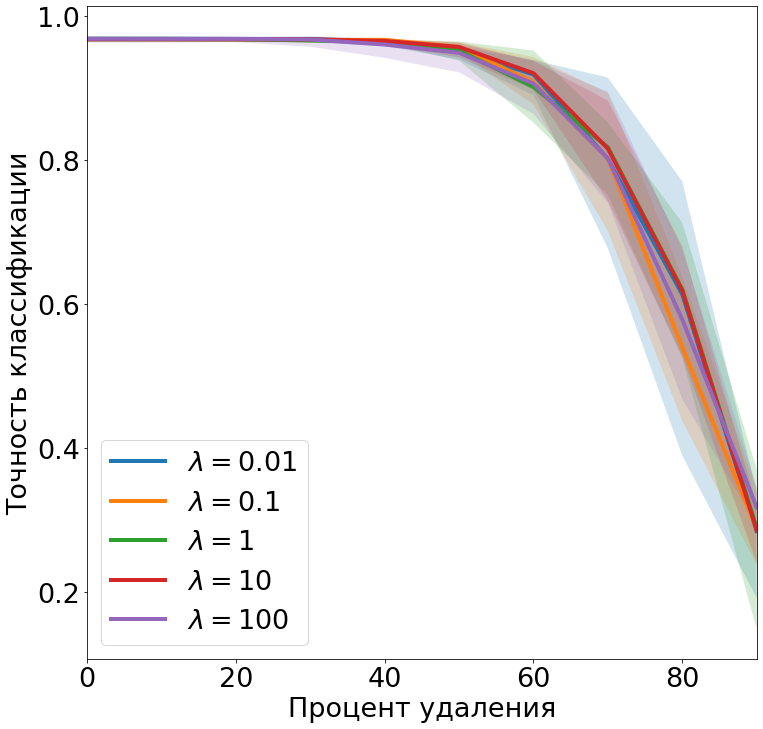

In [12]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('BaseNet.png')
plt.show()


In [ ]:
net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device), 
                     base_net.BaseLayer(hidden_num, 10, device,
                              act=lambda x:x)).to(device)               
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):
        print (lam, s)
        net.load_state_dict(t.load(os.path.join(path_to_save, 'rep_net_lam_{}_start_{}.cpk'.format(lam, s))))
        lam_results[lam].append(utils.delete_10(net, device, lambda:test_acc(net), layer_num=2, mode='base'))
import json
with open(os.path.join(path_to_save, 'results_rep.json'),'w') as out:
    out.write(json.dumps(lam_results)) 

In [ ]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('RepNet.png')
plt.show()

In [13]:
t.manual_seed(0)
for start in range(start_num):         
    net = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(784,  hidden_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
                         linear_var_hypernet.VarLayerLinearAppr(hidden_num, 10,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))
    net = net.to(device)
    optim = t.optim.Adam(net.parameters(), lr=5e-4)
    loss_fn = nn.CrossEntropyLoss().to(device)            
    for e in range(epoch_num):
        label = 'linear, epoch {}: '.format(e)                
        train_batches(net, loss_fn, optim, None, label)
    t.save(net.state_dict(), os.path.join(path_to_save, 'linear_start_{}.cpk'.format( start)))

/mnt/Memory/iad/VarHyperNet/code/src/linear_var_hypernet.py:74: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  init_const)
/mnt/Memory/iad/VarHyperNet/code/src/linear_var_hypernet.py:76: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  init_const2)
linear, epoch 24: 2.8194752: 100%|██████████| 235/235 [00:22<00:00, 10.53it/s]


In [16]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)    
hnet = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(784,  hidden_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
                         linear_var_hypernet.VarLayerLinearAppr(hidden_num, 10,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma)).to(device)    

lam_results = {}
for lam in lambd:
    lam_results[lam] = []
    for s in range(start_num):        
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'linear_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
        lam_results[lam].append(utils.delete_10(net, device, lambda:test_acc(net)))
import json
with open(os.path.join(path_to_save, 'results_linear.json'),'w') as out:
    out.write(json.dumps(lam_results))        

In [ ]:
with open(os.path.join(path_to_save, 'results_linear.json'),'r') as out:
    out.read(json.dumps(lam_results))      

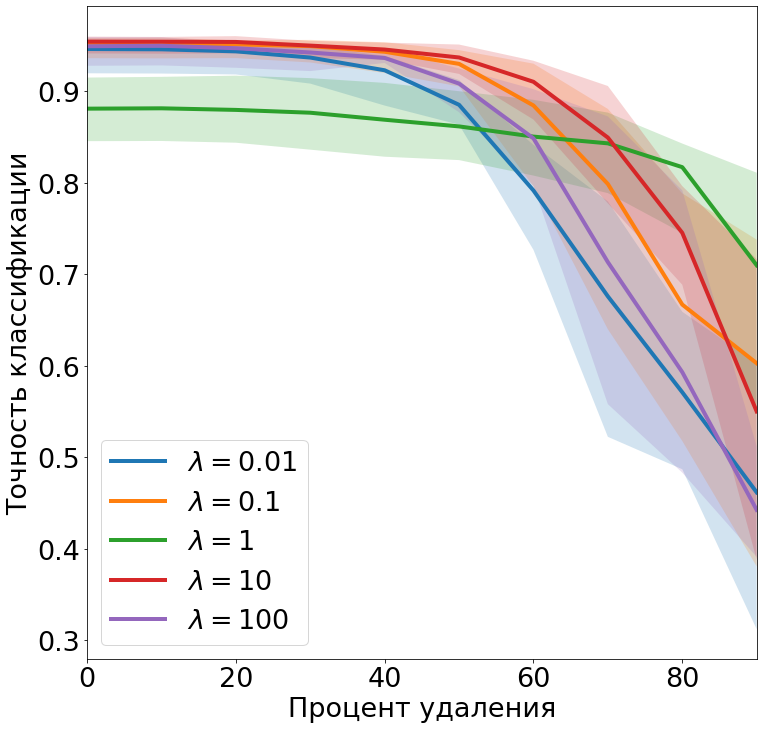

In [18]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Linear_var')
#plt.show()


In [ ]:
t.manual_seed(0)
for start in range(start_num):         
    net = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(784,  hidden_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
                         linear_var_hypernet.VarLayerLinearAppr(hidden_num, 10,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))
    net = net.to(device)
    optim = t.optim.Adam(net.parameters(), lr=5e-4)
    loss_fn = nn.CrossEntropyLoss().to(device)            
    for e in range(epoch_num):
        label = 'linear, epoch {}: '.format(e)                
        train_batches(net, loss_fn, optim, None, label, rep = True)
    t.save(net.state_dict(), os.path.join(path_to_save, 'linear_rep_start_{}.cpk'.format( start)))

In [ ]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)    
hnet = var_net.VarNet(linear_var_hypernet.VarLayerLinearAppr(784,  hidden_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
                         linear_var_hypernet.VarLayerLinearAppr(hidden_num, 10,  prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma)).to(device)    

lam_results = {}
for lam in lambd:
    lam_results[lam] = []
    for s in range(start_num):        
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'linear_rep_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
        lam_results[lam].append(utils.delete_10(net, device, lambda:test_acc(net)))
import json
with open(os.path.join(path_to_save, 'results_linear_rep.json'),'w') as out:
    out.write(json.dumps(lam_results))        

In [ ]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Linear_rep.png')
#plt.show()

In [ ]:
t.manual_seed(0)
for start in range(start_num):         
    net = var_net.VarNet(base_net.BaseLayerLinear(784,  hidden_num),
                         base_net.BaseLayerLinear(hidden_num, 10,  act=lambda x:x))
    net = net.to(device)
    optim = t.optim.Adam(net.parameters(), lr=5e-4)
    loss_fn = nn.CrossEntropyLoss().to(device)            
    for e in range(epoch_num):
        label = 'linear, epoch {}: '.format(e)                
        train_batches(net, loss_fn, optim, None, label)
    t.save(net.state_dict(), os.path.join(path_to_save, 'linear_base_start_{}.cpk'.format( start)))

In [ ]:
net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device), 
                     base_net.BaseLayer(hidden_num, 10, device,
                              act=lambda x:x)).to(device) 

hnet = var_net.VarNet(base_net.BaseLayerLinear(784,  hidden_num),
                         base_net.BaseLayerLinear(hidden_num, 10,  act=lambda x:x)).to(device)  

lam_results = {}
for lam in lambd:
    lam_results[lam] = []
    for s in range(start_num):        
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'linear_base_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam), mode='base')
        lam_results[lam].append(utils.delete_10(net, device, lambda:test_acc(net), mode='base'))
import json
with open(os.path.join(path_to_save, 'results_base_linear.json'),'w') as out:
    out.write(json.dumps(lam_results))        

In [ ]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lambd:
    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('BaseLinear.png')
#plt.show()


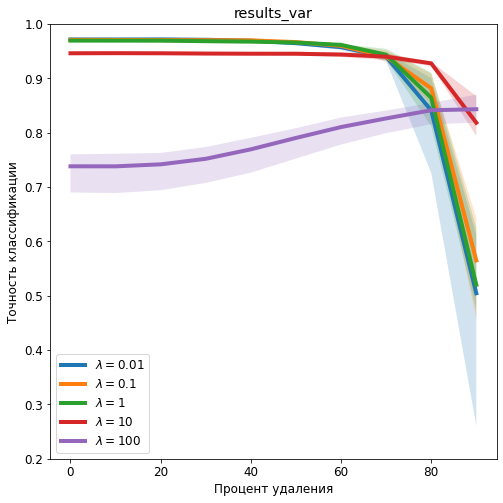

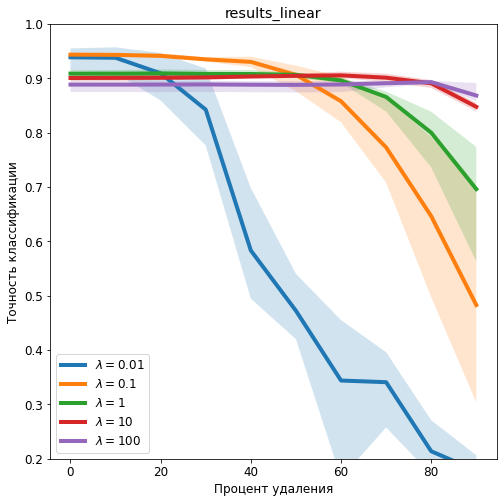

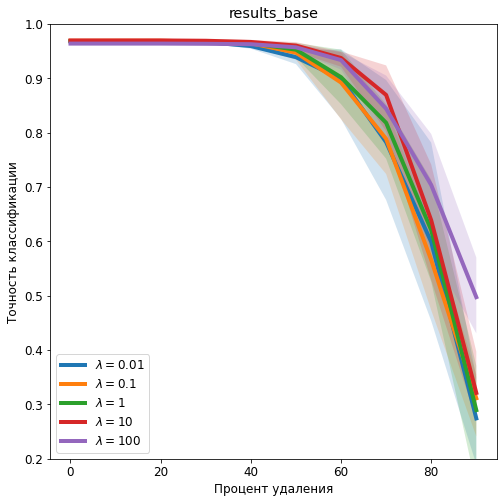

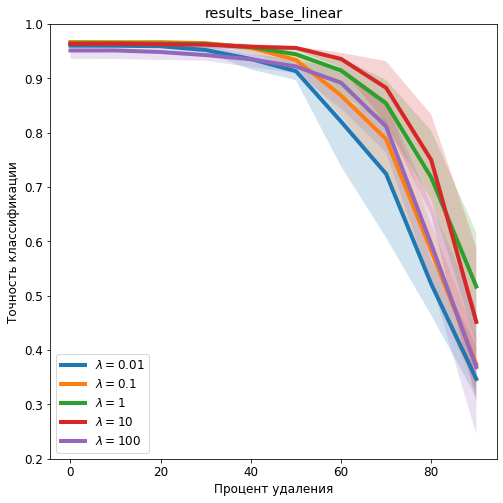

In [13]:
for mode in ['results_var', 'results_linear', 'results_rep', 'results_linear_rep','results_base', 'results_base_linear']:    
    with open(os.path.join(path_to_save, mode+'.json')) as inp:
        lam_results = json.loads(inp.read())
    proc = [0,10,20,30,40,50,60,70,80,90]
    plt.rcParams['figure.figsize'] = 8, 8
    plt.rcParams.update({'font.size': 12})
    plt.rc('lines', linewidth=4)
    plt.title(mode)

    for lam in lamb:
        lam = str(lam)
        plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
        plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
    plt.ylabel('Точность классификации', fontsize = 12)
    plt.xlabel('Процент удаления', fontsize = 12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc='lower left')
    plt.ylim(0.2, 1.0)
    plt.show()
    

[[0.9724 0.9724 0.9709 0.9713 0.9699 0.9653 0.9627 0.9543 0.9291 0.8303]
 [0.971  0.9706 0.9704 0.9707 0.97   0.9651 0.9614 0.9438 0.9231 0.8698]
 [0.9714 0.9715 0.9712 0.9718 0.9715 0.9699 0.9608 0.9471 0.93   0.8185]
 [0.9741 0.974  0.975  0.974  0.9716 0.9663 0.9604 0.9479 0.9277 0.8511]
 [0.9712 0.9708 0.971  0.9705 0.971  0.9677 0.9622 0.9515 0.9275 0.8673]]
[[0.9452 0.9467 0.9409 0.9352 0.933  0.9184 0.9081 0.9071 0.9012 0.869 ]
 [0.9488 0.9493 0.9472 0.9404 0.9205 0.9123 0.9055 0.9047 0.9042 0.8959]
 [0.9522 0.9513 0.9494 0.9394 0.9327 0.9232 0.9122 0.9084 0.903  0.8803]
 [0.957  0.9556 0.9503 0.9423 0.9296 0.9201 0.9059 0.9002 0.8971 0.8585]
 [0.9588 0.9588 0.9515 0.9414 0.9398 0.922  0.9112 0.9025 0.9032 0.8771]]
[[0.9723 0.9723 0.9724 0.9714 0.9707 0.9664 0.9532 0.9014 0.777  0.5703]
 [0.9684 0.9685 0.968  0.9685 0.9663 0.9651 0.9526 0.9237 0.7975 0.542 ]
 [0.9721 0.9718 0.9715 0.9694 0.9681 0.958  0.9343 0.8958 0.7816 0.4612]
 [0.9694 0.9693 0.9692 0.9693 0.9675 0.9663 0.947

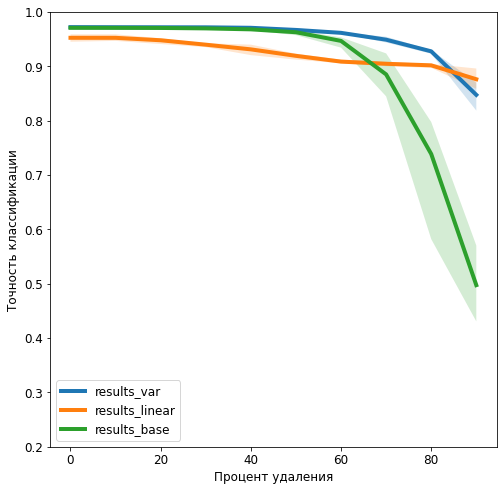

In [23]:
# Этот график - по сути упрощенная таблица: бежим по всем лямбдам и 
# выбираем наилучший результат для фиксированного процента удаленных параметров
# для var и base - результат совпадает с таблицей
# для linear и linear_base - в таблице мы бежим с шагом, а на графике просто перебираем наши лямбды

# из графика видно, что 
# 1. линейная аппроксимация работает нормально. 
# 2. вар сеть бьет base-сеть
# 3. возможно стоит заакцентировать внимани на 90-99% удаленных параметров,
# т.к. ближе к концу начинается самое интересное
for mode in ['results_var', 'results_linear', 'results_base']:    
    with open(os.path.join(path_to_save, mode+'.json')) as inp:
        lam_results = json.loads(inp.read())
    proc = [0,10,20,30,40,50,60,70,80,90]
    plt.rcParams['figure.figsize'] = 8, 8
    plt.rcParams.update({'font.size': 12})
    plt.rc('lines', linewidth=4)    
    arr = np.array(list(lam_results.values()))
    arr = np.moveaxis(arr, [0], [1])
    best_by_lambda = arr.max(1)
    print(best_by_lambda)
    plt.fill_between(proc, np.min(best_by_lambda, 0), np.max(best_by_lambda, 0), alpha=0.2)
    plt.plot(proc, np.mean(best_by_lambda, 0), label=mode)
    plt.ylabel('Точность классификации', fontsize = 12)
    plt.xlabel('Процент удаления', fontsize = 12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc='lower left')
    plt.ylim(0.2, 1.0)
    plt.savefig('All_1')
    

In [9]:
lambd = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80,90, 100]

In [45]:
from collections import OrderedDict

for mode in ['results_base_linear']:    
    with open(os.path.join(path_to_save, mode+'.json')) as inp:
        lam_results = json.loads(inp.read())
        items = lam_results.items()
        sorted_items = sorted(items, key=lambda value: np.mean(value[1][1], axis = None), reverse=True)
        sorted_by_c = OrderedDict(sorted_items)
        print(sorted_items)

[('2', [[0.9625, 0.961, 0.9601, 0.9596, 0.9566, 0.9405, 0.9044, 0.8364, 0.7046, 0.3824], [0.9611, 0.9604, 0.961, 0.9588, 0.9581, 0.9538, 0.9269, 0.8926, 0.8072, 0.6081], [0.9648, 0.9645, 0.9641, 0.9637, 0.96, 0.9492, 0.925, 0.8739, 0.728, 0.4277], [0.9641, 0.9639, 0.9641, 0.9638, 0.9576, 0.9566, 0.9444, 0.8454, 0.7894, 0.4577], [0.9652, 0.9649, 0.9608, 0.9632, 0.9553, 0.9508, 0.9515, 0.9063, 0.7056, 0.517]]), ('4', [[0.9619, 0.9618, 0.9618, 0.9617, 0.9608, 0.9445, 0.9248, 0.8423, 0.7434, 0.4515], [0.9583, 0.9574, 0.9583, 0.9586, 0.9564, 0.9573, 0.954, 0.925, 0.8009, 0.5311], [0.9661, 0.966, 0.966, 0.9625, 0.9579, 0.9557, 0.9466, 0.9118, 0.8403, 0.5033], [0.9654, 0.9653, 0.9658, 0.9659, 0.9639, 0.9493, 0.9334, 0.8859, 0.6919, 0.4424], [0.9644, 0.9634, 0.9642, 0.963, 0.9592, 0.954, 0.9395, 0.8954, 0.7294, 0.311]]), ('3', [[0.9628, 0.9634, 0.9625, 0.9607, 0.9566, 0.9473, 0.8974, 0.8483, 0.7831, 0.3818], [0.9596, 0.9598, 0.9595, 0.9614, 0.958, 0.9524, 0.9465, 0.8914, 0.8354, 0.5189], [0.96

In [ ]:
0.01 0.01 0.01 0.01 0.01 0.1 0.1 0.1 1 10 100
0.02 0.02 0.02 0.06 0.1 0.1 10 10 30 60
10 10 10 10 10 10 0.01 10 100 100
0.2 0.2 0.2 0.2 6 9 6

In [7]:
from mpl_toolkits.mplot3d import Axes3D 

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

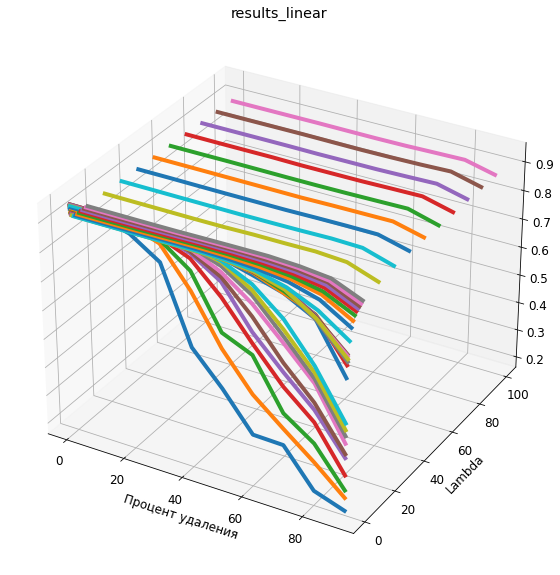

<Figure size 720x720 with 0 Axes>

In [10]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams.update({'font.size': 12})
plt.rc('lines', linewidth=4)
fig = plt.figure()
ax = fig.gca(projection='3d')
    
for mode in ['results_linear']:    
    plt.title(mode)
    with open(os.path.join(path_to_save, mode+'.json')) as inp:
        lam_results = json.loads(inp.read())
    for lam in lambd:
        l = np.ones(10)*lam
        lam = str(lam)
        #plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
        ax.plot(proc, l, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
    plt.ylabel('Lambda', fontsize = 12)
    plt.xlabel('Процент удаления', fontsize = 12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    #plt.legend(loc='lower left')
plt.show()
plt.savefig('3D')

In [ ]:
for mode in ['results_var', 'results_linear', 'results_base']:    
    with open(os.path.join(path_to_save, mode+'.json')) as inp:
        lam_results = json.loads(inp.read())
    proc = [0,10,20,30,40,50,60,70,80,90]
    plt.rcParams['figure.figsize'] = 8, 8
    plt.rcParams.update({'font.size': 12})
    plt.rc('lines', linewidth=4)
    plt.title(mode)

    for lam in lamb:
        lam = str(lam)
        plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
        plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
    plt.ylabel('Точность классификации', fontsize = 12)
    plt.xlabel('Процент удаления', fontsize = 12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc='lower left')
    plt.ylim(0.2, 1.0)
    plt.show()
   

mode: results_var
mode: results_base
mode: results_base_linear
mode: results_linear


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


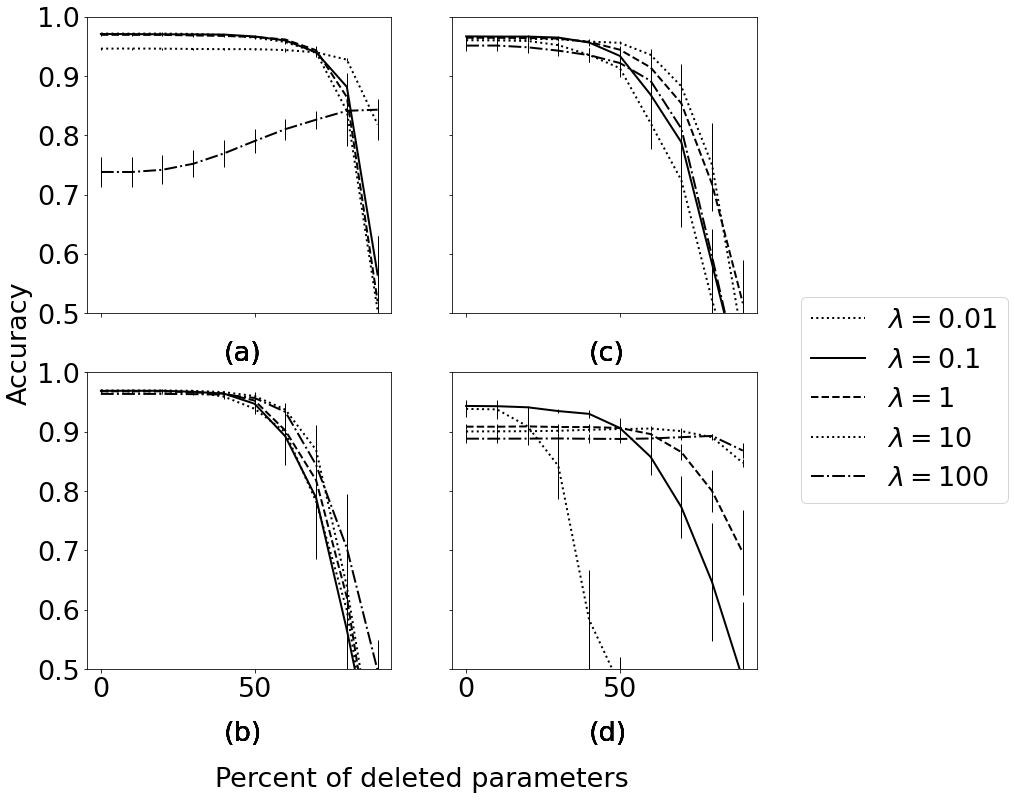

In [21]:
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
proc = [0,10,20,30,40,50,60,70,80,90]
    
fig, axs = plt.subplots(2, 2)
coords = [(0,0), (1,0), (0,1), (1,1)]
titles = ['(a)', '(b)', '(c)', '(d)']
ls = {
    '0.01': ':',
    '0.1':'-',
    '1':'--',
    '10':':',
    '100':'-.'
}
roc = np.array([0,10,20,30,40,50,60,70,80,90])
for id, mode in enumerate(['results_var', 'results_base', 'results_base_linear', 'results_linear']):    
    print ('mode:', mode)
    with open(os.path.join(path_to_save, mode+'.json')) as inp:
        lam_results = json.loads(inp.read())
    current_ax = axs[coords[id][0], coords[id][1]]


    for lam in lamb:
        lam = str(lam)
        
        # вызываем plot и errorbar два раза:
        # (здесь это оказалось ненужным, но оставил на случай переделок:
        # если ошибки разных графиков сильно накладываются, их разносят небольшим сдвигом
        # а сами линии средних значений оставляют на месте)
        
        current_ax.errorbar(proc, np.mean(lam_results[lam], 0), 
                            yerr = np.std(lam_results[lam], 0), 
                            ls = ls[lam],  elinewidth=0, ecolor='black', color=(0,0,0,0), lw=1)
        current_ax.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam), ls = ls[lam], c='k',
                       lw=2)
        
        #current_ax.set_title(titles[id], y=-0.05)
        if id in [1,3,5]:
            current_ax.text(40, .38, titles[id])
        else:
            current_ax.text(40, .42, titles[id])
        current_ax.set_ylim((0.5, 1.0))
        if id != 0 and id != 1:
            current_ax.set_yticklabels([])
        if id not in [1,3,5]:
            current_ax.set_xticklabels([])
        if id == 3:
            current_ax.legend(bbox_to_anchor=(1.1, 1.3))
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel('Accuracy', fontsize = 27)
plt.xlabel('Percent of deleted parameters', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
ax = plt.gca() 
ax.xaxis.set_label_coords(0.5, -0.15) 
plt.autoscale(enable=True, axis='x', tight=True)
#plt.legend(loc='lower left')
plt.savefig('VarHyper.eps', bbox_inches = 'tight')

mode: results_var
mode: results_linear
mode: results_var_pr_s
mode: results_linear_pr_s
mode: results_base
mode: results_base_linear


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


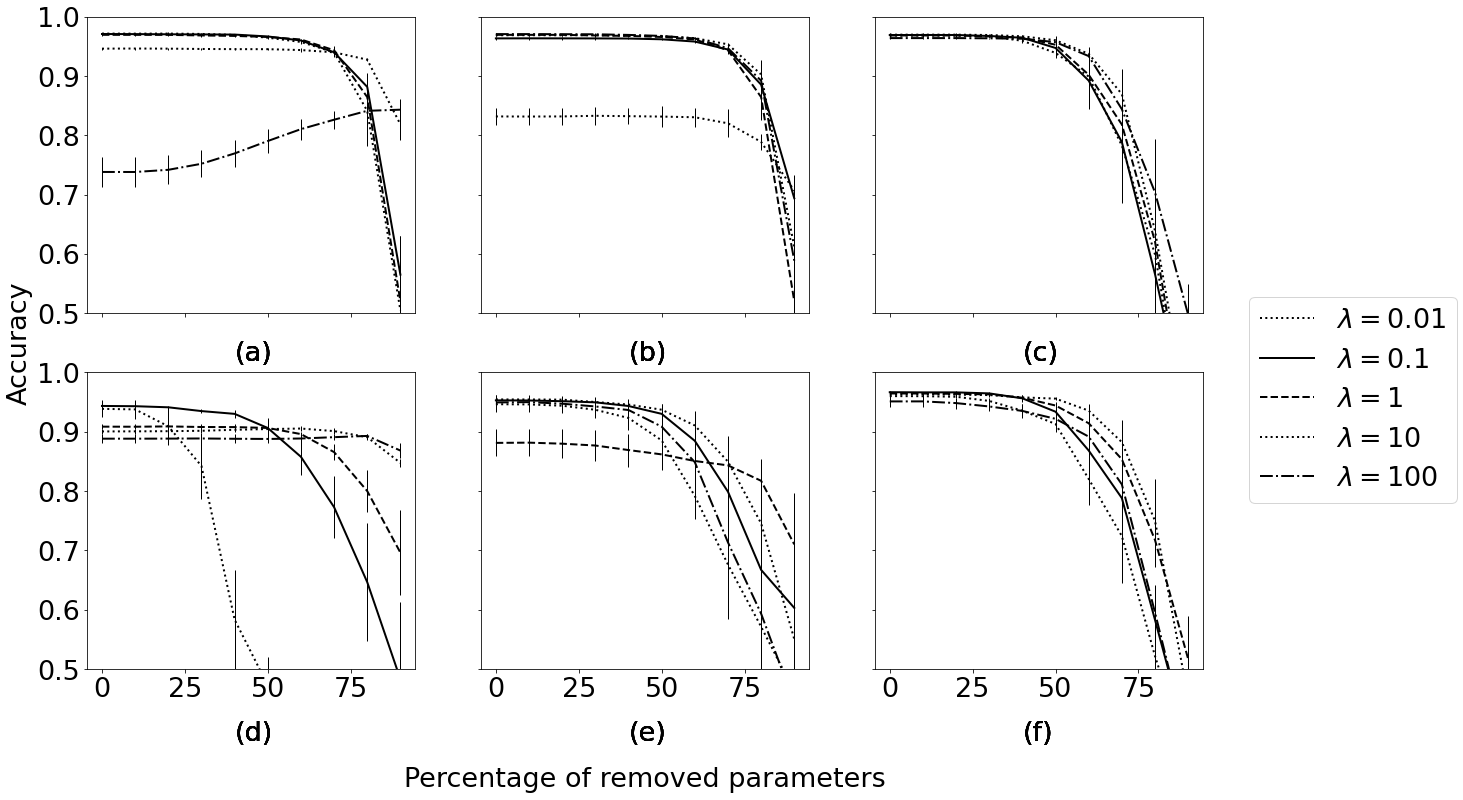

In [13]:
plt.rcParams['figure.figsize'] = 20, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
fig, axs = plt.subplots(2, 3)
coords = [(0,0), (1,0), (0,1), (1,1), (0,2), (1,2)]
titles = ['(a)', '(d)', '(b)', '(e)', '(c)', '(f)']
ls = {
    '0.01': ':',
    '0.1':'-',
    '1':'--',
    '10':':',
    '100':'-.'
}
proc = np.array([0,10,20,30,40,50,60,70,80,90])
for id, mode in enumerate(['results_var', 'results_linear', 'results_var_pr_s', 'results_linear_pr_s',  'results_base', 'results_base_linear']):
    print ('mode:', mode)
    with open(os.path.join(path_to_save, mode+'.json')) as inp:
        lam_results = json.loads(inp.read())
    current_ax = axs[coords[id][0], coords[id][1]]


    for lam in lamb:
        lam = str(lam)
        
        # вызываем plot и errorbar два раза:
        # (здесь это оказалось ненужным, но оставил на случай переделок:
        # если ошибки разных графиков сильно накладываются, их разносят небольшим сдвигом
        # а сами линии средних значений оставляют на месте)
        current_ax.errorbar(proc, np.mean(lam_results[lam], 0), 
                            yerr = np.std(lam_results[lam], 0), 
                            ls = ls[lam],  elinewidth=0, ecolor='black', color=(0,0,0,0), lw=1)
        current_ax.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam), ls = ls[lam], c='k',
                       lw=2)
        
        #current_ax.set_title(titles[id], y=-0.05)
        if id in [1,3,5]:
            current_ax.text(40, .38, titles[id])
        else:
            current_ax.text(40, .42, titles[id])
        current_ax.set_ylim((0.5, 1.0))
        if id != 0 and id != 1:
            current_ax.set_yticklabels([])
        if id not in [1,3,5]:
            current_ax.set_xticklabels([])
        if id == 5:
            current_ax.legend(bbox_to_anchor=(1.1, 1.3))
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)

plt.ylabel('Accuracy', fontsize = 27)
plt.xlabel('Percentage of removed parameters', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
ax = plt.gca() 
ax.xaxis.set_label_coords(0.5, -0.15) 
#plt.autoscale(enable=True, axis='x', tight=False)
#fig.tight_layout()
plt.savefig('VarHyper3netsBlack.eps', bbox_inches = 'tight')
#plt.show()

